# Autoencoder to reproduce spectra

In this notebook we will use the autoencoder architecture from the last notebook (autoencoder_pca) to train an autoencoder to reproduce the spectra.

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
layers = keras.layers

#importing the data
gen = np.loadtxt("spectra_no_qcs.txt", delimiter=",")

#splitting data into train and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(gen, test_size=0.2, random_state=42, shuffle=True, stratify=None)

mean_train = np.mean(train, axis=1, dtype=np.float64)
mean_test = np.mean(test, axis=1, dtype=np.float64)
stddev_train = np.std(train, axis=1, dtype=np.float64)
stddev_test = np.std(test, axis=1, dtype=np.float64)

#standard scaling the training data
from sklearn.preprocessing import StandardScaler
standardscaler_test = StandardScaler()
standardscaler_train = StandardScaler()
test_scaled = standardscaler_test.fit_transform(test)
train= standardscaler_train.fit_transform(train)

In [19]:
test_scaled.shape

(1455, 1101)

In [20]:
stddev_train

array([0.00277393, 0.00265016, 0.00265328, ..., 0.00291064, 0.00248719,
       0.00227989])

In [21]:
train.shape

(5817, 1101)

The autoencoder architecture is a symmetrical, stacked (deep, i.e. more than one hidden layer) autoencoder (https://ebookcentral.proquest.com/lib/ub-lmu/reader.action?docID=4822582)

In [22]:
activation = "elu"
regularizer = keras.regularizers.L1L2(l1=0.01, l2=0.01)

inputlayer = layers.Input(shape=train.shape[1])
e2 = layers.Dense(500, activation=activation)(inputlayer)
e3 = layers.Dense(250, activation=activation)(e2)
#dropout = layers.Dropout(0.3)(e3)
e4 = layers.Dense(100, activation = activation)(e3)

encoded = layers.Dense(50, activation = activation)(e4)

d1 = layers.Dense(100, activation=activation)(encoded)
d2 = layers.Dense(250, activation=activation)(d1)
d3 = layers.Dense(500, activation=activation)(d2)
outputlayer = layers.Dense(1101, activation="linear")(d3)

model = keras.models.Model(inputlayer, outputlayer, name="autoencoder_dense_v1")

print(model.summary())

Model: "autoencoder_dense_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1101)]            0         
                                                                 
 dense_8 (Dense)             (None, 500)               551000    
                                                                 
 dense_9 (Dense)             (None, 250)               125250    
                                                                 
 dense_10 (Dense)            (None, 100)               25100     
                                                                 
 dense_11 (Dense)            (None, 50)                5050      
                                                                 
 dense_12 (Dense)            (None, 100)               5100      
                                                                 
 dense_13 (Dense)            (None, 250)      

In [23]:
#Visualisierung vom Model 
#keras.utils.plot_model(model, show_shapes=True)#, dpi=60)

### Compiling and training the model

In [24]:
model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse')

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
rl_on_plateau= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.67, patience=2,
                                                 verbose=1, min_lr=1e-7)

In [25]:
results = model.fit(train, train,
                          epochs=50,
                          batch_size=128,
                          validation_split=0.1,
                          verbose=1,
                          callbacks=[earlystopping, rl_on_plateau])

Epoch 1/50
41/41 [==============================] - 1s 12ms/step - loss: 0.3035 - val_loss: 0.1115 - lr: 0.0010
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0909 - val_loss: 0.0826 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - 0s 8ms/step - loss: 0.0566 - val_loss: 0.0481 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0365 - val_loss: 0.0380 - lr: 0.0010
Epoch 5/50
41/41 [==============================] - 0s 8ms/step - loss: 0.0314 - val_loss: 0.0564 - lr: 0.0010
Epoch 6/50
37/41 [==========================>...] - ETA: 0s - loss: 0.0769
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
41/41 [==============================] - 0s 9ms/step - loss: 0.0790 - val_loss: 0.1021 - lr: 0.0010
Epoch 6: early stopping


### Tracing the model´s performance

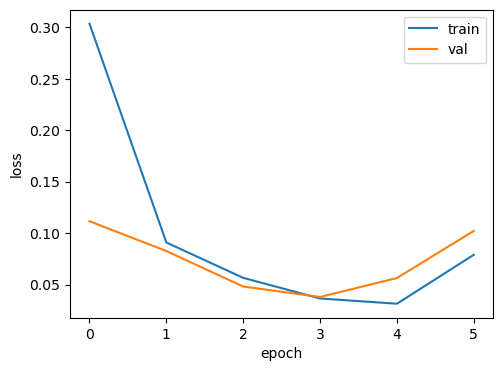

In [26]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

### Reproducing some spectra

In [27]:
preds = model.predict(test_scaled, verbose=1)

46/46 [==============================] - 0s 2ms/step


In [28]:
#Rescaling the data for the plots. Using the StandardScaler from scikit would require to train it. We just do it manually.
#preds_rescaled = [rescale(preds[i], mean_test[i], stddev_test[i]) for i in range(len(preds))]
preds_rescaled = standardscaler_test.inverse_transform(preds)

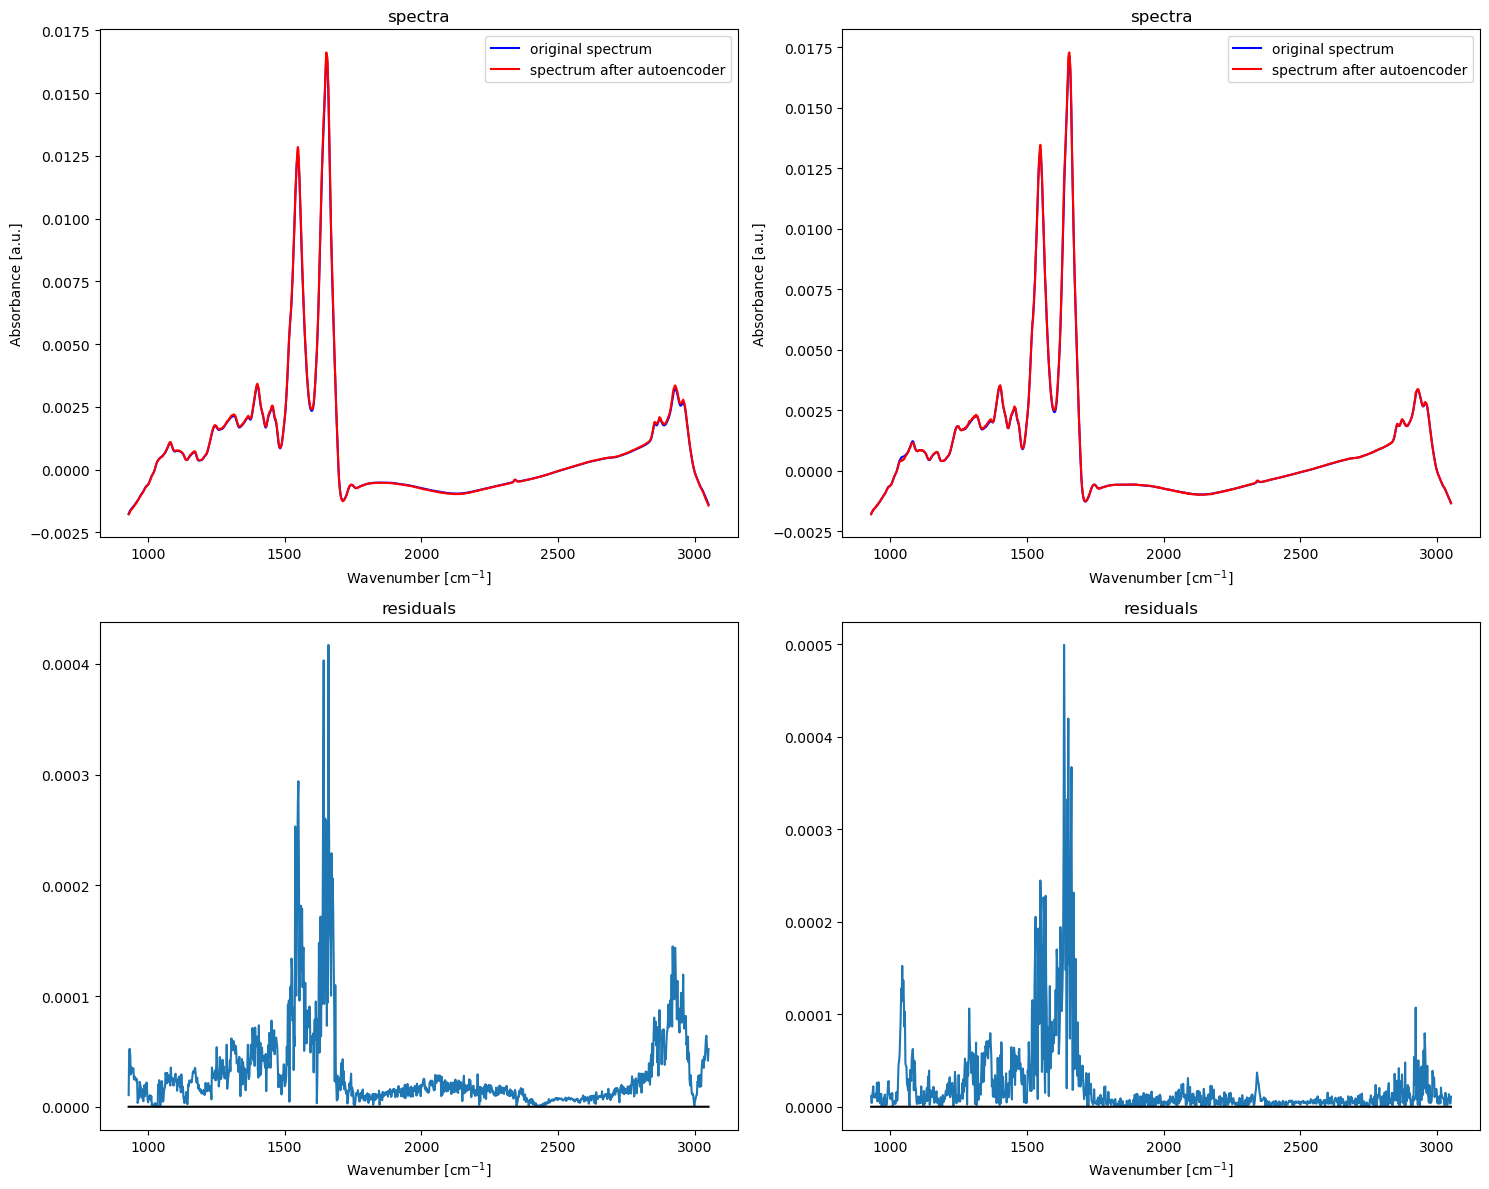

In [29]:
plots = 2
n_test = test.shape[0]
idx = np.random.choice(n_test, plots)
xaxis = np.linspace(929.52720343237377,3050.8548461203636,test.shape[1])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=plots, figsize=(15,12))

for i in range(plots):
    ax1[i].plot(xaxis, test[idx[i]],'b', markersize= 0.5, label="original spectrum")
    ax1[i].plot(xaxis, preds_rescaled[idx[i]], 'r', markersize=0.5, label="spectrum after autoencoder")
    
    ax1[i].legend(loc=1)
    ax1[i].set_ylabel('Absorbance [a.u.]')
    ax1[i].set_xlabel('Wavenumber [cm$^{-1}$]')
    ax2[i].set_xlabel('Wavenumber [cm$^{-1}$]')
    ax1[i].set_title("spectra")

    ax2[i].plot(xaxis, np.abs(test[idx[i]]-preds_rescaled[idx[i]]), label="residuals")
    ax2[i].plot(xaxis, np.zeros(xaxis.shape), 'k')
    
    ax2[i].set_title("residuals")
    
plt.tight_layout()
plt.show()

I changed the following things in the architecture to get a nice result:
Increased the number of nodes in the latent space
Changed the number of nodes in the other hidden layers
Changed the activation function from relu to tanh, which enabled the fitting of negative values in the spectra.

Now we want to see whether the model is able to reproduce the properties of the spectra in a way that they are distinguishable from other spectra. We will perform a PCA on the real data (not QC's) and on the reproduced spectra of the real data. Then we plot 10 real spectra examples and their reproduced versions in the PCA-plot and see if we can relate the spectra pairs to each other. They should be closer to each other than to other pairs in the plot.

In [11]:
import pandas as pd
import json as js
import os.path

"""
csv_path = "C:/Users/corinna.wegner/Documents/real_data.csv"
spectra_path = "//z-sv-dfsroot/dfsroot/project/agzigman/MIRA Anaylzer - Eval/L4L_all_samples/Serum"

data = pd.read_csv(csv_path, delimiter=",", header=0)
absorbances = []

# loading 10 random examples
rand = np.random.randint(1, len(data), size=10)
for i in rand:
    ID = data["File Name"][i] + ".json"
    spectrum_path_id ="%s/%s"%(spectra_path,ID) 
    if os.path.isfile(spectrum_path_id):
        f = open(spectrum_path_id, "r")
        spect = js.loads(f.read(), strict=False)
        ab_data = spect["AB Data"]
        ab_data = list(reversed(ab_data))
        absorbances.append(ab_data)
    
absorbances = np.array(absorbances)
from sklearn.preprocessing import StandardScaler
absorbances = StandardScaler().fit_transform(absorbances)

"""

absorbances = []

#PCA of 10 examples from test set
rand = np.random.randint(1, len(test_scaled), size=10)
for i in rand:
    absorbances.append(test_scaled[i])
absorbances = np.array(absorbances)

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

#performing PCA on the examples
principalComponents = pca.fit_transform(absorbances)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

#passing the examples to the autoencoder and performing PCA again
model_preds = model.predict(absorbances, verbose=1)
principalComponents_preds = pca.fit_transform(model_preds)
principalDf_preds = pd.DataFrame(data = principalComponents_preds, columns = ['principal component 1', 'principal component 2'])

#plotting the results
xaxis = list(principalDf["principal component 1"])
yaxis = list(principalDf["principal component 2"])
xaxis_preds = list(principalDf_preds["principal component 1"])
yaxis_preds = list(principalDf_preds["principal component 2"])

plt.plot(xaxis, yaxis, 'go', label = "original data ")
plt.plot(xaxis_preds, yaxis_preds, 'ro', label = "autoencoder outputs")
plt.title("PCA comparison between original and decoded spectra")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")

1/1 [==============================] - 0s 14ms/step


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').